In [1]:
import pandas as pd

# Define file paths (input is the large dataset, output is a smaller sample for testing)
input_path = "sudoku.csv"
output_path = "sudoku_sample.csv"

# Load only the first 100 rows to create a small working sample
df = pd.read_csv(input_path, nrows=100)

# Save the sample as a new CSV file
df.to_csv(output_path, index=False)

print(f"Sample saved to {output_path}")

Sample saved to sudoku_sample.csv


In [ ]:
# ------------------- Imports and Utility Functions -------------------
import numpy as np
import pandas as pd
import random
import time
import matplotlib.pyplot as plt
import math
import copy

# Convert a string of 81 digits to a 9x9 Sudoku grid
def string_to_grid(s):
    return np.array([int(c) for c in s.strip()]).reshape((9, 9))

# Convert a 9x9 grid back to a single string of 81 digits
def grid_to_string(grid):
    return ''.join(str(cell) for cell in grid.flatten())

# Count how many cells are filled in the grid
def count_clues(grid):
    return np.count_nonzero(grid)

def compute_difficulty_thresholds(df):
    clue_counts = df['puzzle'].apply(lambda p: count_clues(string_to_grid(p)))
    min_clues = clue_counts.min()
    max_clues = clue_counts.max()

    # Divide the range into 4 equal buckets
    interval = (max_clues - min_clues) / 4
    thresholds = {
        "Easy": min_clues + 3 * interval,
        "Medium": min_clues + 2 * interval,
        "Hard": min_clues + 1 * interval,
        "Expert": min_clues
    }
    return thresholds

# Apply thresholds dynamically
def classify_difficulty(clue_count, thresholds):
    if clue_count >= thresholds["Easy"]:
        return "Easy"
    elif clue_count >= thresholds["Medium"]:
        return "Medium"
    elif clue_count >= thresholds["Hard"]:
        return "Hard"
    else:
        return "Expert"
# ------------------- Sudoku Board State -------------------

# Class to represent the Sudoku board state
class SudokuState:
    def __init__(self, board):
        self.board = board

    def is_terminal(self):
        # A state is terminal if there are no empty cells
        return all(all(cell != 0 for cell in row) for row in self.board)

    def get_empty_cells(self):
        return [(r, c) for r in range(9) for c in range(9) if self.board[r][c] == 0]

    def clone(self):
        return SudokuState(copy.deepcopy(self.board))

    def __hash__(self):
        return hash(str(self.board))

    def __eq__(self, other):
        return self.board == other.board


In [3]:
# ------------------- CSP Solver (with MRV and LCV heuristics) -------------------

# Check if placing a number is valid in the given row, column, and 3x3 box
def is_valid(grid, row, col, num):
    box_row, box_col = 3 * (row // 3), 3 * (col // 3)
    return not (
        num in grid[row, :] or
        num in grid[:, col] or
        num in grid[box_row:box_row+3, box_col:box_col+3]
    )

# Minimum Remaining Values (MRV): Find the empty cell with the fewest valid options
def find_mrv(grid):
    min_count, best_cell = 10, None
    for i in range(9):
        for j in range(9):
            if grid[i, j] == 0:
                options = [num for num in range(1, 10) if is_valid(grid, i, j, num)]
                if len(options) < min_count:
                    min_count = len(options)
                    best_cell = (i, j)
    return best_cell

# Least Constraining Value (LCV): Prioritize values that constrain other cells the least
def least_constraining_values(grid, row, col):
    options = [num for num in range(1, 10) if is_valid(grid, row, col, num)]
    return sorted(options, key=lambda num: -sum(
        is_valid(grid, i, j, num)
        for i in range(9) for j in range(9)
        if grid[i, j] == 0
    ))

# Solve the Sudoku using backtracking with MRV and LCV
def solve_csp(grid):
    cell = find_mrv(grid)
    if not cell:
        return True  # Solved
    row, col = cell
    for num in least_constraining_values(grid, row, col):
        if is_valid(grid, row, col, num):
            grid[row, col] = num
            if solve_csp(grid):
                return True
            grid[row, col] = 0  # Backtrack
    return False


In [4]:
# ------------------- CSP Solver (Naive - No MRV or LCV) -------------------

# Solve the Sudoku using simple backtracking: pick the first empty cell found
def solve_csp_naive(grid):
    for row in range(9):
        for col in range(9):
            if grid[row, col] == 0:
                for num in range(1, 10):
                    if is_valid(grid, row, col, num):
                        grid[row, col] = num
                        if solve_csp_naive(grid):
                            return True
                        grid[row, col] = 0  # Backtrack if needed
                return False  # No valid number found, trigger backtracking
    return True  # All cells filled successfully


In [ ]:
# ------------------- MCTS Solver with Tree Search -------------------

# Find all empty cells in the Sudoku grid
def find_empty_cells(grid):
    return [(i, j) for i in range(9) for j in range(9) if grid[i, j] == 0]

# Get initial domain possibilities for each empty cell
def get_initial_domains(board):
    domains = {}
    for r in range(9):
        for c in range(9):
            if board[r][c] == 0:
                domains[(r, c)] = [v for v in range(1, 10) if is_valid_move(board, r, c, v)]
    return domains

# Check if placing a value at a cell is valid
def is_valid_move(board, row, col, value):
    for i in range(9):
        if board[row][i] == value or board[i][col] == value:
            return False
    box_r, box_c = 3 * (row // 3), 3 * (col // 3)
    for i in range(3):
        for j in range(3):
            if board[box_r + i][box_c + j] == value:
                return False
    return True

# Select the cell with the fewest domain options (MRV)
def select_mrv_cell(domains):
    return min(domains.items(), key=lambda x: len(x[1]), default=(None, []))[0]

# Update domains after assigning a value to a cell
def update_domains(domains, row, col, value):
    keys = list(domains.keys())
    for (r, c) in keys:
        if r == row or c == col or (r // 3, c // 3) == (row // 3, col // 3):
            if value in domains[(r, c)]:
                domains[(r, c)].remove(value)
                if not domains[(r, c)]:
                    del domains[(r, c)]

# Perform a random rollout to estimate success
def rollout(state):
    board = copy.deepcopy(state.board)
    while True:
        domains = get_initial_domains(board)
        if not domains:
            break
        cell = select_mrv_cell(domains)
        if cell is None:
            break
        r, c = cell
        v = random.choice(domains[(r, c)])
        board[r][c] = v
    return SudokuState(board).is_terminal()

# Check if a board is solvable
def is_solvable(board):
    def is_valid(board, row, col, num):
        for i in range(9):
            if i != col and board[row][i] == num:
                return False
            if i != row and board[i][col] == num:
                return False
        start_row, start_col = 3 * (row // 3), 3 * (col // 3)
        for i in range(3):
            for j in range(3):
                r, c = start_row + i, start_col + j
                if (r != row or c != col) and board[r][c] == num:
                    return False
        return True

    for row in range(9):
        for col in range(9):
            num = board[row][col]
            if num != 0:
                if not is_valid(board, row, col, num):
                    return False
    return True

# Node class for MCTS
class MCTSNode:
    def __init__(self, state, parent=None, action=None):
        self.state = state
        self.parent = parent
        self.children = []
        self.visits = 0
        self.wins = 0
        self.action = action

    def expand(self):
        board = self.state.board
        domains = get_initial_domains(board)
        cell = select_mrv_cell(domains)
        if not cell:
            return

        r, c = cell
        for v in domains[(r, c)]:
            new_board = copy.deepcopy(board)
            new_board[r][c] = v
            if is_solvable(new_board):
                new_state = SudokuState(new_board)
                self.children.append(MCTSNode(new_state, parent=self, action=(r, c, v)))

    def best_child(self, c_param=1.4):
        choices_weights = [
            (child.wins / child.visits) + c_param * math.sqrt(math.log(self.visits) / child.visits)
            for child in self.children
        ]
        return self.children[choices_weights.index(max(choices_weights))]

    def backpropagate(self, result):
        self.visits += 1
        self.wins += result
        if self.parent:
            self.parent.backpropagate(result)

    def is_fully_expanded(self):
        return len(self.children) > 0

    def best_action(self, simulations_number):
        try:
            for _ in range(simulations_number):
                v = self.tree_policy()
                reward = rollout(v.state)
                v.backpropagate(reward)
            return max(self.children, key=lambda node: node.visits)
        except:
            return None

    def tree_policy(self):
        current_node = self
        while not current_node.state.is_terminal():
            if not current_node.is_fully_expanded():
                current_node.expand()
                if current_node.children:
                    return random.choice(current_node.children)
                else:
                    return current_node
            else:
                current_node = current_node.best_child()
        return current_node

# Solve Sudoku using MCTS with tree search
def solve_mcts(puzzle, max_iterations=100):
    root = MCTSNode(SudokuState(puzzle))
    for i in range(max_iterations):
        best = root.best_action(10)
        if best is None:
            break
        root = MCTSNode(SudokuState(best.state.board))
        if root.state.is_terminal():
            return root.state.board, i
    return root.state.board, i


In [ ]:
# ------------------- Evaluation Function -------------------

def evaluate_solvers(df, max_puzzles=None, classify_func=None):
    results = []
    rows = df.iterrows() if max_puzzles is None else df.head(max_puzzles).iterrows()

    for idx, row in rows:
        puzzle = string_to_grid(row['puzzle'])
        true_solution = row['solution']
        clue_count = count_clues(puzzle)

        # --- KEY LINE: use dynamic classification if provided
        if classify_func:
            difficulty = classify_func(clue_count)
        else:
            difficulty = classify_difficulty(clue_count)
        if idx % 20 == 0:
            print(f"Solving puzzle #{idx} ({difficulty})")

        # --- CSP MRV+LCV ---
        start = time.time()
        csp_grid = puzzle.copy()
        csp_success = solve_csp(csp_grid)
        csp_time = time.time() - start
        csp_correct = grid_to_string(csp_grid) == true_solution

        # --- CSP Naive ---
        start = time.time()
        csp_naive_grid = puzzle.copy()
        csp_naive_success = solve_csp_naive(csp_naive_grid)
        csp_naive_time = time.time() - start
        csp_naive_correct = grid_to_string(csp_naive_grid) == true_solution

        # --- MCTS Tree Search ---
        start = time.time()
        mcts_grid = puzzle.copy()
        mcts_solution, iterations = solve_mcts(mcts_grid)
        mcts_time = time.time() - start
        mcts_correct = grid_to_string(mcts_solution) == true_solution
        mcts_success = mcts_solution is not None

        # --- Store results ---
        results.append({
            'index': idx,
            'difficulty': difficulty,
            'csp_success': csp_success,
            'csp_correct': csp_correct,
            'csp_time': round(csp_time, 4),
            'csp_naive_success': csp_naive_success,
            'csp_naive_correct': csp_naive_correct,
            'csp_naive_time': round(csp_naive_time, 4),
            'mcts_success': mcts_success,
            'mcts_correct': mcts_correct,
            'mcts_time': round(mcts_time, 4),
            'mcts_iterations': iterations
        })

    # Save results
    df_out = pd.DataFrame(results)
    df_out.to_csv("full_solver_results.csv", index=False)
    return df_out


In [ ]:
# ------------------- Accuracy per Difficulty (Bar Chart) -------------------

def visualize_solver_results(df_results):
    import matplotlib.pyplot as plt

    # Calculate overall metrics
    avg_csp_time = df_results['csp_time'].mean()
    avg_csp_naive_time = df_results['csp_naive_time'].mean()
    avg_mcts_time = df_results['mcts_time'].mean()

    csp_accuracy = df_results['csp_correct'].mean()
    csp_naive_accuracy = df_results['csp_naive_correct'].mean()
    mcts_accuracy = df_results['mcts_correct'].mean()

    csp_success_rate = df_results['csp_success'].mean()
    csp_naive_success_rate = df_results['csp_naive_success'].mean()
    mcts_success_rate = df_results['mcts_success'].mean()

    solvers = ['CSP MRV+LCV', 'CSP Naive', 'MCTS Tree']
    avg_times = [avg_csp_time, avg_csp_naive_time, avg_mcts_time]
    accuracies = [csp_accuracy, csp_naive_accuracy, mcts_accuracy]
    success_rates = [csp_success_rate, csp_naive_success_rate, mcts_success_rate]

    # --- Plot Average Solve Times ---
    plt.figure(figsize=(8, 5))
    plt.bar(solvers, avg_times)
    plt.ylabel('Average Solve Time (seconds)')
    plt.title('Solver Speed Comparison')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # --- Plot Overall Accuracy ---
    plt.figure(figsize=(8, 5))
    plt.bar(solvers, accuracies)
    plt.ylabel('Accuracy (Correct Solutions %)')
    plt.title('Solver Accuracy Comparison')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # --- Plot Overall Success Rate ---
    plt.figure(figsize=(8, 5))
    plt.bar(solvers, success_rates)
    plt.ylabel('Success Rate (Any Solution Found %)')
    plt.title('Solver Success Rate Comparison')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    difficulties = ['Easy', 'Medium', 'Hard', 'Expert']

    # Group results by difficulty
    grouped = df_results.groupby('difficulty')

    # Calculate accuracy for each solver per difficulty
    csp_difficulty_acc = grouped['csp_correct'].mean().reindex(difficulties)
    csp_naive_difficulty_acc = grouped['csp_naive_correct'].mean().reindex(difficulties)
    mcts_difficulty_acc = grouped['mcts_correct'].mean().reindex(difficulties)

    # Create a grouped bar chart
    x = range(len(difficulties))
    bar_width = 0.25

    plt.figure(figsize=(10, 6))
    plt.bar([p - bar_width for p in x], csp_difficulty_acc, width=bar_width, label='CSP MRV+LCV')
    plt.bar(x, csp_naive_difficulty_acc, width=bar_width, label='CSP Naive')
    plt.bar([p + bar_width for p in x], mcts_difficulty_acc, width=bar_width, label='MCTS Tree')

    plt.xticks(x, difficulties)
    plt.ylabel('Accuracy')
    plt.title('Solver Accuracy by Puzzle Difficulty')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


Solving puzzle #0 (Hard)
Solving puzzle #20 (Expert)
Solving puzzle #40 (Hard)
Solving puzzle #60 (Hard)
Solving puzzle #80 (Hard)
Solving puzzle #100 (Expert)
Solving puzzle #120 (Hard)
Solving puzzle #140 (Hard)
Solving puzzle #160 (Expert)
Solving puzzle #180 (Hard)
Solving puzzle #200 (Expert)
Solving puzzle #220 (Hard)
Solving puzzle #240 (Expert)
Solving puzzle #260 (Hard)
Solving puzzle #280 (Expert)
Solving puzzle #300 (Hard)
Solving puzzle #320 (Expert)
Solving puzzle #340 (Expert)
Solving puzzle #360 (Expert)
Solving puzzle #380 (Hard)
Solving puzzle #400 (Medium)
Solving puzzle #420 (Hard)
Solving puzzle #440 (Expert)
Solving puzzle #460 (Hard)
Solving puzzle #480 (Hard)
Solving puzzle #500 (Medium)
Solving puzzle #520 (Hard)
Solving puzzle #540 (Hard)
Solving puzzle #560 (Hard)
Solving puzzle #580 (Hard)
Solving puzzle #600 (Hard)
Solving puzzle #620 (Expert)
Solving puzzle #640 (Hard)
Solving puzzle #660 (Medium)
Solving puzzle #680 (Expert)
Solving puzzle #700 (Expert)
So

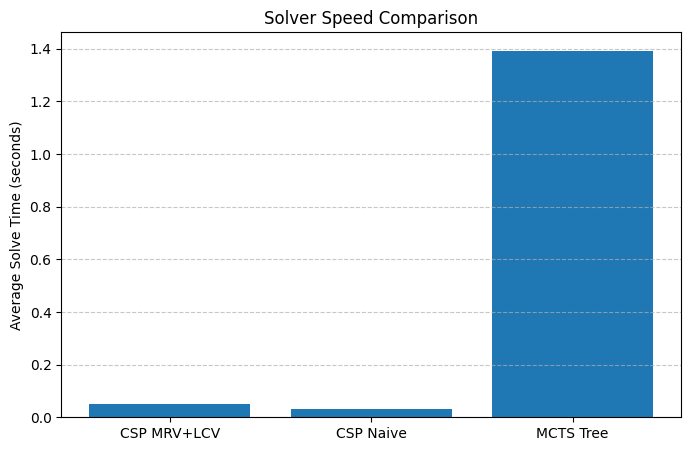

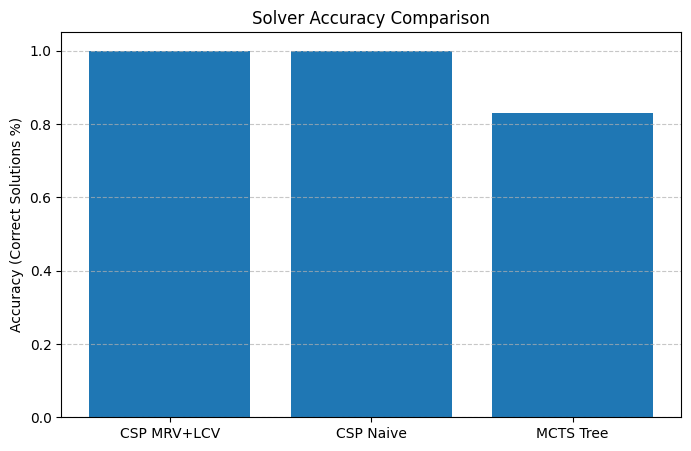

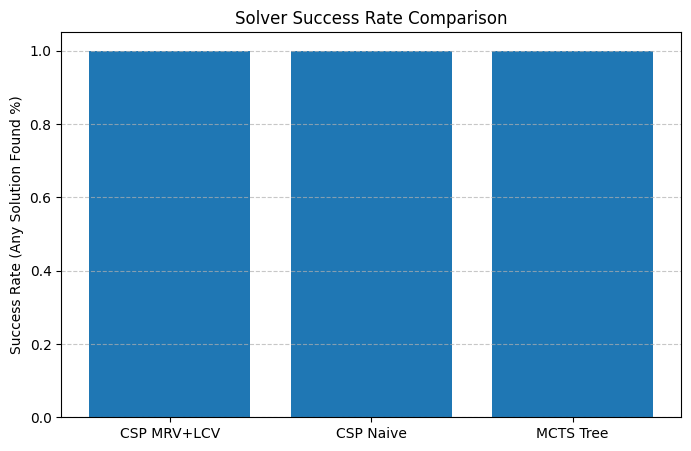

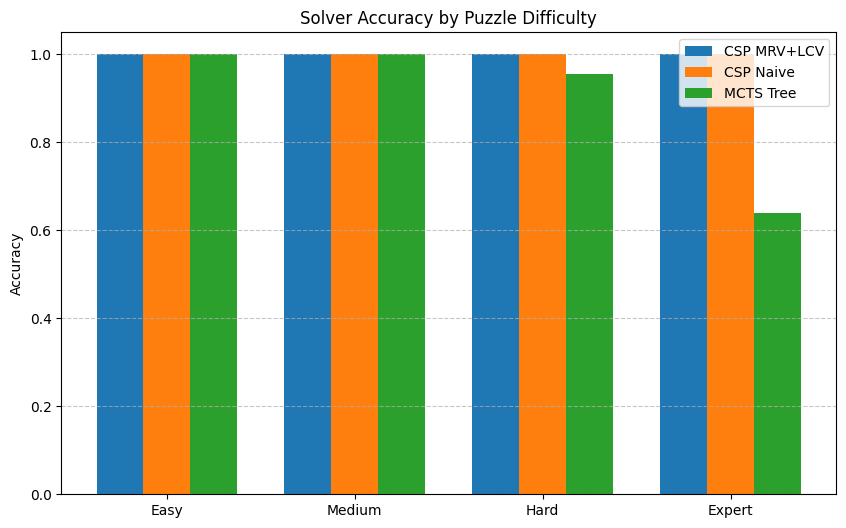

In [ ]:
# ------------------- Main Execution Block -------------------

if __name__ == "__main__":
    
    df_puzzles = pd.read_csv("sudoku.csv")

    # Dynamically compute difficulty thresholds
    thresholds = compute_difficulty_thresholds(df_puzzles)

    # Redefine classify_difficulty to use dynamic thresholds
    def classify_dynamic(clue_count):
        if clue_count >= thresholds["Easy"]:
            return "Easy"
        elif clue_count >= thresholds["Medium"]:
            return "Medium"
        elif clue_count >= thresholds["Hard"]:
            return "Hard"
        else:
            return "Expert"

    #  Evaluate all solvers
    df_results = evaluate_solvers(df_puzzles, max_puzzles=1000, classify_func=classify_dynamic)

    #  Visualize the results
    visualize_solver_results(df_results)
